# Машинное обучение, ФКН ВШЭ

## Практическое задание 3. Градиентный спуск своими руками

### Общая информация
Дата выдачи: **23.10.2023**

Мягкий дедлайн: **08.11.23 23:59**

Жесткий дедлайн: **12.11.23 23:59**

### О задании

В данном задании необходимо реализовать обучение линейной регрессии с помощью различных вариантов градиентного спуска.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов + 2 балла бонус.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо считываемые диаграммы.

Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.


### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-03-gd-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: ...

Напомним, что на лекциях и семинарах мы разбирали некоторые подходы к оптимизации функционалов по параметрам. В частности, был рассмотрен градиентный спуск и различные подходы к его реализации — полный градиентный спуск, стохастический градиентный спуск, метод импульса и другие. В качестве модели у нас будет выступать линейная регрессия.

В этом домашнем задании вам предстоит реализовать 4 различных вариации градиентного спуска, написать свою реализацию линейной регресии, сравнить методы градиентного спуска между собой на реальных данных и ещё много чего веселого и интересного!

## Задание 1. Реализация градиентного спуска (3.5 балла)

В этом задании вам предстоит написать собственные реализации различных подходов к градиентному спуску с опорой на подготовленные шаблоны в файле `descents.py`.

**Все реализуемые методы должны быть векторизованы!**

### Лирическое-теоретическое отступление № 1

Основное свойство антиградиента &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента,
пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (например, нулевой или сгенерированный из некоторого
случайного распределения). Тогда ванильный градиентный спуск состоит в повторении следующих шагов до сходимости:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

### Лирическое-теоретическое отступление № 2

На семинаре про [матрично-векторное дифференцирование](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/seminars/sem03-vector-diff.pdf) вы должны были обсуждать дифференцирование функции потерь MSE в матричном виде.

### Задание 1.0. Градиент MSE в матричном виде (0 баллов).

Напомним, что функция потерь MSE записывается в матричном виде как:

$$
    Q(w) = \dfrac{1}{\ell} \left( y - Xw \right)^T \left( y - Xw \right)
$$

Выпишите ниже (подсмотрев в семинар или решив самостоятельно) градиент для функции потерь MSE в матричном виде.

$$
\nabla_wQ = -\frac{2}{l}(y-Xw)^TX
$$

### Задание 1.1. Родительский класс BaseDescent (0.5 балла).

Реализуйте функции `calc_loss` (вычисление MSE для переданных $x$ и $y$) и `predict` (предсказание $y_{pred}$ для переданных $x$) в классе `BaseDescent`.

Все вычисления должны быть векторизованы.

In [1]:
from dataclasses import dataclass
from enum import auto
from enum import Enum
from typing import Dict
from typing import Type

import numpy as np

In [2]:
@dataclass
class LearningRate:
    lambda_: float = 1e-3
    s0: float = 1
    p: float = 0.5

    iteration: int = 0

    def __call__(self):
        """
        Calculate learning rate according to lambda (s0/(s0 + t))^p formula
        """
        self.iteration += 1
        return self.lambda_ * (self.s0 / (self.s0 + self.iteration)) ** self.p


class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()

class BaseDescent:
    """
    A base class and templates for all functions
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        """
        :param dimension: feature space dimension
        :param lambda_: learning rate parameter
        :param loss_function: optimized loss function
        """
        self.dim = dimension
        self.w: np.ndarray = np.random.rand(dimension)
        self.lr: LearningRate = LearningRate(lambda_=lambda_)
        self.loss_function: LossFunction = loss_function

    def step(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.update_weights(self.calc_gradient(x, y))

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculate loss for x and y with our weights
        :param x: features array
        :param y: targets array
        :return: loss: float
        """
        w = self.w
        n_observations = len(y)
        # assert y.shape == (n_observations, ), f"{y.shape}"
        # assert x.shape == (n_observations, self.dim), f"{x.shape}"
        # assert w.shape == (self.dim, ), f"{w.shape}"

        y_pred = self.predict(x)
        mse = ((y - y_pred.T).T @ (y - y_pred.T) ) / n_observations
        return mse

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Calculate predictions for x
        :param x: features array
        :return: prediction: np.ndarray
        """
        w = self.w

        prediction = x @ w
        return prediction


In [3]:
def init_test():
    num_objects = 100
    dimension = 5

    x = np.random.rand(num_objects, dimension)
    y = np.random.rand(num_objects)

    return x,y,dimension

x, y, dimenstion = init_test()
descent = BaseDescent(dimenstion)

descent.calc_loss(x,y)

0.31379029058299956

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def generate_and_plot_data(plot=True):
    num_objects = 100
    dimension = 5
    noise_stddev = 0.1

    x = np.random.rand(num_objects, dimension)
    coefficients = np.array([1, 2, 3, 4, 5])  # Coefficients for each x_i
    y = np.dot(x, coefficients)

    # Add random noise to y values
    noise = np.random.normal(0, noise_stddev, num_objects)
    y += noise

    if plot:
        # Create a scatter plot
        plt.scatter(y, x[:, 0], label='x1')
        plt.scatter(y, x[:, 1], label='x2')
        plt.scatter(y, x[:, 2], label='x3')
        plt.scatter(y, x[:, 3], label='x4')
        plt.scatter(y, x[:, 4], label='x5')

        plt.xlabel('y')
        plt.ylabel('x values')
        plt.legend()
        plt.title('Generated Data with Noise')
        plt.show()

    return x, y, dimension

$$
y = x_1 + 2x_2 + 3x_3 + 4x_4 + 5x_5
$$

### Задание 1.2. Полный градиентный спуск VanillaGradientDescent (0.5 балла).

Реализуйте полный градиентный спуск заполнив пропуски в классе `VanillaGradientDescent` в файле `descents.py`. Для вычисления градиента используйте формулу выше. Шаг оптимизации:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

Здесь и далее функция `update_weights` должна возвращать разницу между $w_{k + 1}$ и $w_{k}$: $\quad w_{k + 1} - w_{k} = -\eta_{k} \nabla_{w} Q(w_{k})$.

Во всех методах градиентного спуска мы будем использовать следующую формулу для длины шага:

$$
    \eta_{k} = \lambda \left(\dfrac{s_0}{s_0 + k}\right)^p
$$

На практике достаточно настроить параметр $\lambda$, а остальным выставить параметры по умолчанию: $s_0 = 1, \, p = 0.5.$

In [5]:
class VanillaGradientDescent(BaseDescent):
    """
    Full gradient descent class
    """

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        # step_size = self.lr * gradient
        w_diff = -(self.lr() * gradient)
        self.w += w_diff

        return w_diff

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        # -2/l(y-Xw)^T X
        w = self.w
        assert y.shape == (len(y), ), y.shape
        assert w.shape == (self.dim, ), w.shape
        assert x.shape == (len(y), self.dim), x.shape

        grad = -(2/len(y)) * (y - (x @ w)).T @ x
        assert grad.shape == w.shape

        return grad

In [6]:
x,y,dim = init_test()

van_desc = VanillaGradientDescent(dim)

grad = van_desc.calc_gradient(x,y)
print(grad)

van_desc.update_weights(grad)

[-0.26629347 -0.2611023  -0.28928632 -0.26687619 -0.22162769]


array([0.0001883 , 0.00018463, 0.00020456, 0.00018871, 0.00015671])

## Test

In [7]:
def test_descend(descent_cls, args: dict = {}, iters = 10e6):

    x,y,dim = generate_and_plot_data(False)
    descend = descent_cls(dim, **args)
    iters = int(iters)

    for i in range(iters):
        descend.w += descend.step(x, y)
        if i % (iters / 25) == 0:
            print(descend.calc_loss(x, y))
    print(descend.calc_loss(x, y))
    print("\nWeights: ", descend.w)

    return descend

In [8]:
# d = test_descend(VanillaGradientDescent, iters = 10e6)

### Лирическое-теоретическое отступление № 3

Как правило, в задачах машинного обучения функционал $Q(w)$ представим в виде суммы $\ell$ функций:

$$
    Q(w)
    =
    \frac{1}{\ell}
    \sum_{i = 1}^{\ell}
        q_i(w).
$$

В нашем домашнем задании отдельные функции $q_i(w)$ соответствуют ошибкам на отдельных объектах.

Проблема метода градиентного спуска состоит в том, что на каждом шаге необходимо вычислять градиент всей суммы (будем его называть полным градиентом):

$$
    \nabla_w Q(w)
    =
    \frac{1}{\ell}
    \sum_{i = 1}^{\ell}
        \nabla_w q_i(w).
$$

Это может быть очень трудоёмко при больших размерах выборки. В то же время точное вычисление градиента может быть не так уж необходимо &ndash; как правило, мы делаем не очень большие шаги в сторону антиградиента, и наличие в нём неточностей не должно сильно сказаться на общей траектории.

Оценить градиент суммы функций можно средним градиентов случайно взятого подмножества функций:

$$
    \nabla_{w} Q(w_{k}) \approx \dfrac{1}{|B|}\sum\limits_{i \in B}\nabla_{w} q_{i}(w_{k}),
$$
где $B$ - это случайно выбранное подмножество индексов.

В этом случае мы получим метод **стохастического градиентного спуска**.

### Задание 1.3. Стохастический градиентный спуск StochasticDescent (0.5 балла).

Реализуйте стохастический градиентный спуск заполнив пропуски в классе `StochasticDescent`. Для оценки градиента используйте формулу выше (среднее градиентов случайно выбранного батча объектов). Шаг оптимизации:

$$
    w_{k + 1} = w_{k} - \eta_{k} \dfrac{1}{|B|}\sum\limits_{i \in B}\nabla_{w} q_{i}(w_{k}).
$$

Размер батча будет являться гиперпараметром метода, семплируйте индексы для батча объектов с помощью `np.random.randint`.

In [9]:
class StochasticDescent(VanillaGradientDescent):
    """
    Stochastic gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, batch_size: int = 50,
                 loss_function: LossFunction = LossFunction.MSE):
        """
        :param batch_size: batch size (int)
        """
        super().__init__(dimension, lambda_, loss_function)
        self.batch_size = batch_size

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
         # -2/l(y-Xw)^T X
         # where y.shape = (1, ),  x.shape = (1, dim)

        w = self.w

        assert y.shape == (len(y), ), y.shape
        assert w.shape == (self.dim, ), w.shape
        assert x.shape == (len(y), self.dim), x.shape

        indices_subset = np.random.randint(0, len(y), size=self.batch_size)
        x_subset = np.take(x, indices_subset, axis=0)
        y_subset = y[indices_subset]

        assert x_subset.shape == (self.batch_size, self.dim), x_subset.shape

        # gradients = np.vectorize(lambda x_obs, y_obs, w: -2 * (y_obs - (x_obs @ w)).T @ x)(x_subset, y_subset, w)
        gradients = -2 * (y_subset - (x_subset @ w)).T @ x_subset

        assert gradients.shape == (self.dim, ), gradients.shape

        return gradients / self.batch_size

In [10]:
# descend = test_descend(StochasticDescent, iters=10e6)

In [11]:
# descend = test_descend(StochasticDescent, {"batch_size": 1})

### Лирическое-теоретическое отступление № 4

Может оказаться, что направление антиградиента сильно меняется от шага к шагу. Например, если линии уровня функционала сильно вытянуты, то из-за ортогональности градиента линиям уровня он будет менять направление на почти противоположное на каждом шаге. Такие осцилляции будут вносить сильный шум в движение, и процесс оптимизации займёт много итераций. Чтобы избежать этого, можно усреднять векторы антиградиента с нескольких предыдущих шагов &ndash; в этом случае шум уменьшится, и такой средний вектор будет указывать в сторону общего направления движения. Введём для этого вектор инерции:

\begin{align}
    &h_0 = 0, \\
    &h_{k + 1} = \alpha h_{k} + \eta_k \nabla_w Q(w_{k})
\end{align}

Здесь $\alpha$ &ndash; параметр метода, определяющей скорость затухания градиентов с предыдущих шагов. Разумеется, вместо вектора градиента может быть использована его аппроксимация. Чтобы сделать шаг градиентного спуска, просто сдвинем предыдущую точку на вектор инерции:

$$
    w_{k + 1} = w_{k} - h_{k + 1}.
$$

Заметим, что если по какой-то координате градиент постоянно меняет знак, то в результате усреднения градиентов в векторе инерции эта координата окажется близкой к нулю. Если же по координате знак градиента всегда одинаковый, то величина соответствующей координаты в векторе инерции будет большой, и мы будем делать большие шаги в соответствующем направлении.

### Задание 1.4 Метод Momentum MomentumDescent (0.5 балла).

Реализуйте градиентный спуск с методом инерции заполнив пропуски в классе `MomentumDescent`. Шаг оптимизации:

\begin{align}
    &h_0 = 0, \\
    &h_{k + 1} = \alpha h_{k} + \eta_k \nabla_w Q(w_{k}) \\
    &w_{k + 1} = w_{k} - h_{k + 1}.
\end{align}

$\alpha$ будет являться гиперпараметром метода, но в данном домашнем задании мы зафиксируем её за вас $\alpha = 0.9$.

In [12]:
class MomentumDescent(VanillaGradientDescent):
    """
    Momentum gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.alpha: float = 0.9

        self.h: np.ndarray = np.zeros(dimension)

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        self.h = self.alpha * self.h + self.lr() * gradient
        self.w -= self.h
        return -self.h

In [13]:
# descend = test_descend(MomentumDescent, iters=10e5 * 3)

### Лирическое-теоретическое отступление № 5

Градиентный спуск очень чувствителен к выбору длины шага. Если шаг большой, то есть риск, что мы будем перескакивать через точку минимума; если же шаг маленький, то для нахождения минимума потребуется много итераций. При этом нет способов заранее определить правильный размер шага &ndash; к тому же, схемы с постепенным уменьшением шага по мере итераций могут тоже плохо работать.

В методе AdaGrad предлагается сделать свою длину шага для каждой компоненты вектора параметров. При этом шаг будет тем меньше, чем более длинные шаги мы делали на предыдущих итерациях:

\begin{align}
    &G_{kj} = G_{k-1,j} + (\nabla_w Q(w_{k - 1}))_j^2; \\
    &w_{jk} = w_{j,k-1} - \frac{\eta_t}{\sqrt{G_{kj}} + \varepsilon} (\nabla_w Q(w_{k - 1}))_j.
\end{align}

Здесь $\varepsilon$ небольшая константа, которая предотвращает деление на ноль.

В данном методе можно зафксировать длину шага (например, $\eta_k = 0.01$) и не подбирать её в процессе обучения. Отметим, что данный метод подходит для разреженных задач, в которых у каждого объекта большинство признаков равны нулю. Для признаков, у которых ненулевые значения встречаются редко, будут делаться большие шаги; если же какой-то признак часто является ненулевым, то шаги по нему будут небольшими.

У метода AdaGrad есть большой недостаток: переменная $G_{kj}$ монотонно растёт, из-за чего шаги становятся всё медленнее и могут остановиться ещё до того, как достигнут минимум функционала. Проблема решается в методе RMSprop, где используется экспоненциальное затухание градиентов:

$$
    G_{kj} = \alpha G_{k-1,j} + (1 - \alpha) (\nabla_w Q(w^{(k-1)}))_j^2.
$$

В этом случае размер шага по координате зависит в основном от того, насколько
быстро мы двигались по ней на последних итерациях.

Можно объединить идеи описанных выше методов: накапливать градиенты со всех прошлых шагов для
избежания осцилляций и делать адаптивную длину шага по каждому параметру.

### Задание 1.5. Метод Adam (Adaptive Moment Estimation) (1.5 балла).

![](adam_meme.png)

Реализуйте градиентный спуск с методом Adam заполнив пропуски в классе `Adam`. Шаг оптимизации:

\begin{align}
    &m_0 = 0, \quad v_0 = 0; \\ \\
    &m_{k + 1} = \beta_1 m_k + (1 - \beta_1) \nabla_w Q(w_{k}); \\ \\
    &v_{k + 1} = \beta_2 v_k + (1 - \beta_2) \left(\nabla_w Q(w_{k})\right)^2; \\ \\
    &\widehat{m}_{k} = \dfrac{m_k}{1 - \beta_1^{k}}, \quad \widehat{v}_{k} = \dfrac{v_k}{1 - \beta_2^{k}}; \\ \\
    &w_{k + 1} = w_{k} - \dfrac{\eta_k}{\sqrt{\widehat{v}_{k + 1}} + \varepsilon} \widehat{m}_{k + 1}. \\
    &w_{k+1} - w_k = - \dfrac{\eta_k}{\sqrt{\widehat{v}_{k + 1}} + \varepsilon} \widehat{m}_{k + 1}
\end{align}

$\beta_1 = 0.9, \beta_2 = 0.999$ и $\varepsilon = 10^{-8}$ будут зафиксированы за вас.

In [14]:
class Adam(VanillaGradientDescent):
    """
    Adaptive Moment Estimation gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.eps: float = 1e-8

        self.m: np.ndarray = np.zeros(dimension)
        self.v: np.ndarray = np.zeros(dimension)

        self.beta_1: float = 0.9
        self.beta_2: float = 0.999

        self.iteration: int = 0

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        self.iteration += 1

        # we have J observations
        self.m = self.beta_1 * self.m + ( (1 - self.beta_1) * gradient )
        self.v = self.beta_2 * self.v + ( (1 - self.beta_2) * (gradient * gradient) )

        m_est = self.m / (1 - self.beta_1 ** self.iteration)
        v_est = self.v / (1 - self.beta_2 ** self.iteration)

        w_diff = -self.lr() / (np.sqrt(v_est) + self.eps) * m_est
        self.w += w_diff

        assert w_diff.shape == (self.dim, ), w_diff.shape
        return w_diff

In [15]:
# d = test_descend(Adam)

## Задание 2. Реализация линейной регресии (0.5 балла)

В этом задании вам предстоит написать свою реализацию линейной регресии, обучаемой с использованием градиентного спуска, с опорой на подготовленные шаблоны в файле `linear_regression.py` - **LinearRegression**. По сути линейная регрессия будет оберткой, которая запускает обучение

Необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы;
* Циклы средствами python допускаются только для итераций градиентного спуска;
* В качестве критерия останова необходимо использовать (одновременно):
    * Квадрат евклидовой нормы разности весов на двух соседних итерациях меньше `tolerance`;
    * Разность весов содержит наны;
    * Достижение максимального числа итераций `max_iter`.
* Будем считать, что все данные, которые поступают на вход имеют столбец единичек последним столбцом;
* Чтобы проследить за сходимостью оптимизационного процесса будем использовать `loss_history`, в нём будем хранить значения функции потерь до каждого шага, начиная с нулевого (до первого шага по антиградиенту) и значение функции потерь после оптимизации.

In [16]:
from __future__ import annotations

from typing import List

import numpy as np
# from descents import BaseDescent
# from descents import get_descent

class LinearRegression:
    def __init__(self, descent_config: dict, tolerance: float = 1e-4, max_iter: int = 300):
        self.descent = get_descent(descent_config)
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.loss_history = []

    def fit(self, x: np.ndarray, y: np.ndarray) -> LinearRegression:
        w = self.descent.w
        for i in range(self.max_iter):
            # add loss_history before weight change
            self.loss_history += [self.calc_loss(x, y)]
            # change weights
            w_diff = self.descent.step(x, y)
            # conditions for break
            if np.isnan(w_diff).any() or np.power(np.linalg.norm(w_diff), 2)  < self.tolerance:
                break
        self.loss_history += [self.calc_loss(x, y)]
        return self

    def predict(self, x: np.ndarray) -> np.ndarray:
        return self.descent.predict(x)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        return self.descent.calc_loss(x, y)


## Задание 3. Проверка кода (0 баллов)

In [17]:
%reload_ext autoreload

In [18]:
%autoreload 2

import numpy as np

In [19]:
num_objects = 100
dimension = 5

x = np.random.rand(num_objects, dimension)
y = np.random.rand(num_objects)

In [20]:
# Descents
from descents import get_descent

descent_config = {
    'descent_name': 'some name that we will replace in the future',
    'kwargs': {
        'dimension': dimension
    }
}

for descent_name in ['full', 'stochastic', 'momentum', 'adam']:
    descent_config['descent_name'] = descent_name
    descent = get_descent(descent_config)

    print(descent_name)
    diff = descent.step(x, y)
    gradient = descent.calc_gradient(x, y)
    predictions = descent.predict(x)

    assert gradient.shape[0] == dimension, f'Gradient failed for descent {descent_name}'
    assert diff.shape[0] == dimension, f'Weights failed for descent {descent_name}'
    assert predictions.shape == y.shape, f'Prediction failed for descent {descent_name}'

full
stochastic
momentum
adam


In [21]:
# LinearRegression

max_iter = 10
tolerance = 0

descent_config = {
    'descent_name': 'stochastic',
    'kwargs': {
        'dimension': dimension,
        'batch_size': 10
    }
}

regression = LinearRegression(
    descent_config=descent_config,
    tolerance=tolerance,
    max_iter=max_iter
)

regression.fit(x, y)

assert len(regression.loss_history) == max_iter + 1, 'Loss history failed' + str(len(regression.loss_history))

In [22]:
regression.loss_history

[1.2555444021516369,
 1.2513948720001864,
 1.246017334470642,
 1.243653682171191,
 1.2401724543563448,
 1.2386790828499472,
 1.2368693442155967,
 1.2337417263120134,
 1.2318221972477603,
 1.2304893965199548,
 1.2287917060364861]

Если ваше решение прошло все тесты локально, то теперь пришло время протестировать его в [Яндекс Контесте](https://contest.yandex.ru/contest/54610/).

Для каждой задачи из контеста вставьте ссылку на успешную посылку:

* **VanillaGradientDescent**:
https://contest.yandex.ru/contest/54610/run-report/95892852/

* **StochasticDescent**:
https://contest.yandex.ru/contest/54610/run-report/95893263/


* **MomentumDescent**:
https://contest.yandex.ru/contest/54610/run-report/95893675/

* **Adam**:
https://contest.yandex.ru/contest/54610/run-report/95961040/

* **LinearRegression**:
https://contest.yandex.ru/contest/54610/run-report/96009676/

## Задание 4. Работа с данными (1 балл)

Мы будем использовать датасет объявлений по продаже машин на немецком Ebay. В задаче предсказания целевой переменной для нас будет являться цена.

* Постройте график распределения целевой переменной в данных, подумайте, нужно ли заменить её на логарифм. Присутствуют ли выбросы в данных с аномальной ценой? Если да, то удалите их из данных.

* Проведите исследование данных:
    * Проанализируйте тип столбцов, постройте графики зависимости целевой переменной от признака, распределения значений признака;
    * Подумайте, какие признаки могут быть полезными на основе этих графиков, обработайте выбросы;
    * Подумайте, какие трансформации признаков из известных вам будет уместно применить;
    * Разделите полезные признаки на категориальные, вещественные и те, которые не надо предобрабатывать.
* Разделите данные на обучающую, валидационную и тестовую выборки в отношении 8:1:1.

In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from descents import get_descent
from linear_regression import LinearRegression

sns.set(style='darkgrid')

In [24]:
data = pd.read_csv('autos.csv')

In [25]:
data.head()

,brand,model,vehicleType,gearbox,fuelType,notRepairedDamage,powerPS,kilometer,autoAgeMonths,price
0,volkswagen,golf,kleinwagen,manuell,benzin,nein,75,150000,177,1500
1,skoda,fabia,kleinwagen,manuell,diesel,nein,69,90000,93,3600
2,bmw,3er,limousine,manuell,benzin,ja,102,150000,246,650
3,peugeot,2_reihe,cabrio,manuell,benzin,nein,109,150000,140,2200
4,mazda,3_reihe,limousine,manuell,benzin,nein,105,150000,136,2000


Колонки в данных:

* `brand` - название бренда автомобиля
* `model` - название модели автомобиля
* `vehicleType` - тип транспортного средства
* `gearbox` - тип трансмисcии
* `fuelType` - какой вид топлива использует автомобиль
* `notRepairedDamage` - есть ли в автомобиле неисправность, которая еще не устранена
* `powerPS` - мощность автомобиля в PS (метрическая лошадиная сила)
* `kilometer` - сколько километров проехал автомобиль, пробег
* `autoAgeMonths` - возраст автомобиля в месяцах


* `price` - цена, указанная в объявлении о продаже автомобиля (целевая переменная)

In [26]:
categorical = ["brand", "model", "vehicleType", "gearbox", "fuelType", "notRepairedDamage", ]
numeric = ["powerPS", "kilometer", "autoAgeMonths"]
other = []
columns_to_drop = []

# YOUR CODE (EDA):

(0.0, 40000.0)

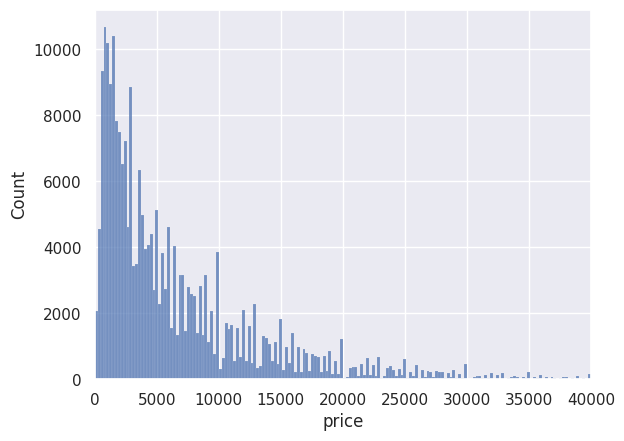

In [27]:
sns.histplot(data.price)
plt.xlim(0, 40_000)

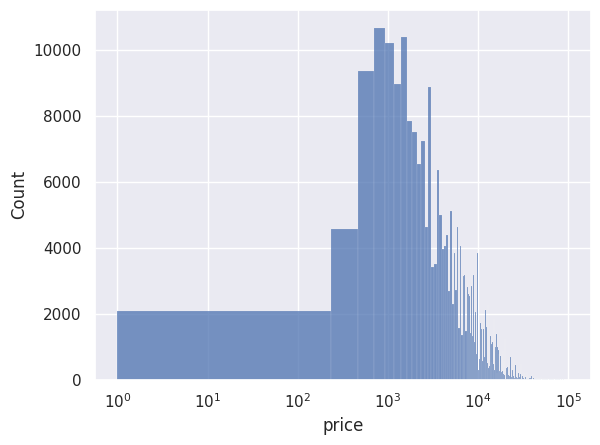

In [28]:
sns.histplot(data.price)
plt.xscale("log")

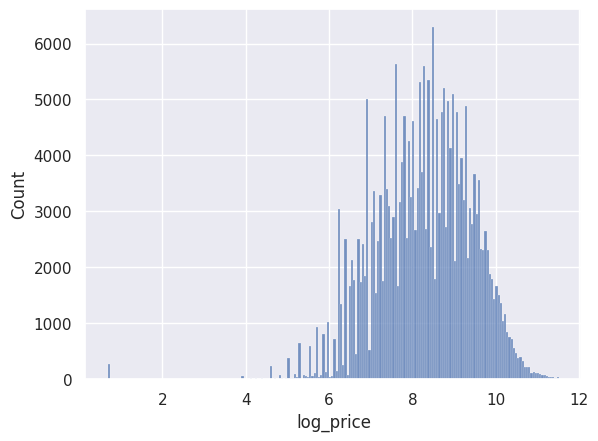

In [29]:
data["log_price"] = np.log1p(data["price"])
sns.histplot(data["log_price"])
columns_to_drop.append("price")

In [ ]:
data = data[(data["log_price"] > 4) & (data["log_price"] < 11)]
sns.histplot(data["log_price"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Исследование данных

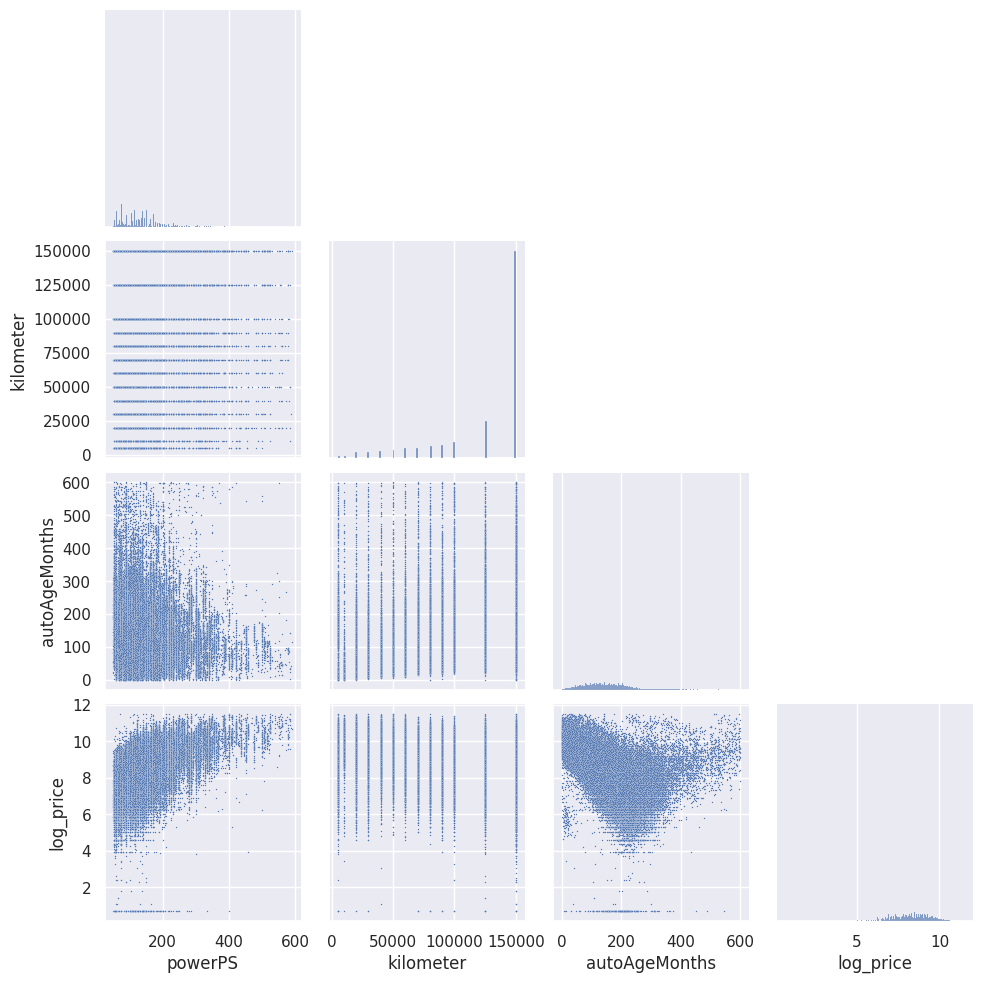

In [30]:
sns.pairplot(data.drop(columns=["price"]), corner=True, plot_kws={"s": 1})

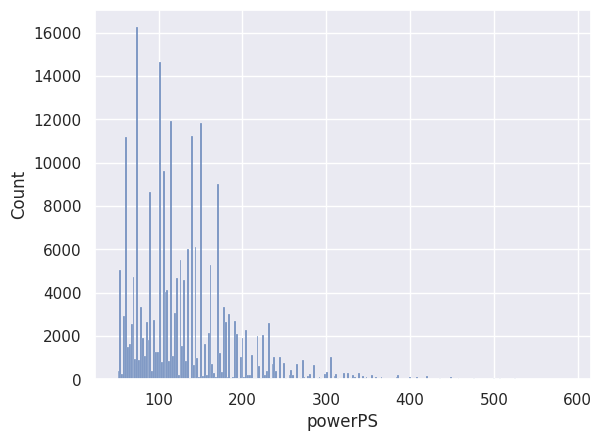

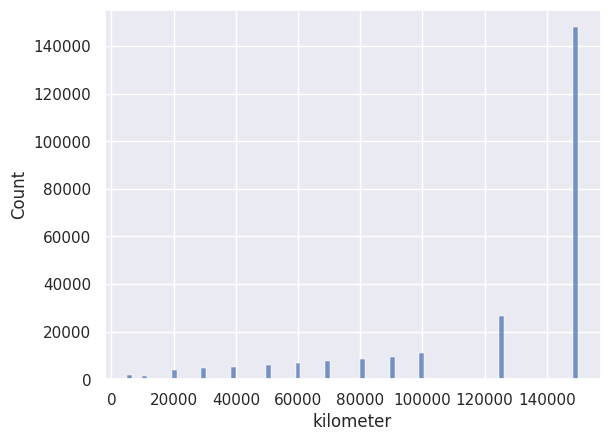

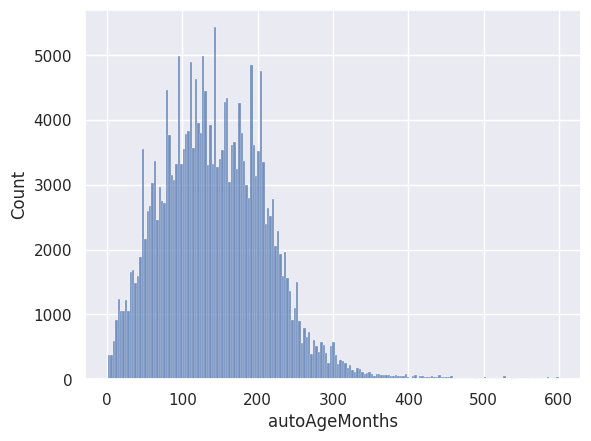

In [31]:
for col in numeric:
    sns.histplot(data[col])
    plt.show()

In [32]:
data = data[data["autoAgeMonths"] < 400]

In [33]:
data.describe()

,powerPS,kilometer,autoAgeMonths,price,log_price
count,239686.000000,239686.000000,239686.000000,239686.000000,239686.000000
mean,131.267629,123874.798695,142.676110,6853.471517,8.261610
std,60.582916,39754.021507,68.213793,7966.052061,1.152244
min,51.000000,5000.000000,1.000000,1.000000,0.693147
25%,90.000000,100000.000000,91.000000,1750.000000,7.467942
50%,120.000000,150000.000000,139.000000,4000.000000,8.294300
75%,160.000000,150000.000000,191.000000,8990.000000,9.103979
max,589.000000,150000.000000,399.000000,99999.000000,11.512925


In [34]:
data["brand"].nunique(), data["model"].nunique(), data["vehicleType"].nunique(), data.shape[0]

(38, 247, 8, 239686)

In [35]:
data['bias'] = 1
other += ['bias']

x = data[categorical + numeric + other]
y = data['log_price']

x.columns

Index(['brand', 'model', 'vehicleType', 'gearbox', 'fuelType',
       'notRepairedDamage', 'powerPS', 'kilometer', 'autoAgeMonths', 'bias'],
      dtype='object')

In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric),
    ('other',  'passthrough', other)
])

x = column_transformer.fit_transform(x)

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape)

(191748, 308) (23969, 308) (23969, 308)
(191748,)


## Задание 5. Сравнение методов градиентного спуска (2 балла)

В этом задании вам предстоит сравнить методы градиентного спуска на подготовленных вами данных из предыдущего задания.

### Задание 5.1. Подбор оптимальной длины шага (1 балл)

Подберите по валидационной выборке наилучшую длину шага $\lambda$ для каждого метода с точки зрения ошибки. Для этого сделайте перебор по логарифмической сетке. Для каждого метода посчитайте ошибку на обучающей и тестовой выборках, посчитайте качество по метрике $R^2$, сохраните количество итераций до сходимости.

Все параметры кроме `lambda_` стоит выставить равным значениям по умолчанию.

In [38]:
type(X_train.toarray()), type(y_train.to_numpy())

(numpy.ndarray, numpy.ndarray)

In [109]:
from sklearn.model_selection import GridSearchCV

lambdas = [1e-2, 1e-1, 1]
descents = ["full", "stochastic", "momentum", "adam"]

best_lambdas = []

X_train_np = X_train.toarray()
y_train_np = y_train.to_numpy()

limit = int(0.1 * len(X_train_np))
# for faster computation, can be interchanged with full training dataset. I get it that quatity of model becomes worse, but i want to pass this HW before deadline
X_train_lite, y_train_lite = X_train_np[:limit, : ], y_train_np[:limit]

In [110]:
error_history = {name: [] for name in descents}

models = {}

for descent_name in descents:
    errors = []
    models_buf = []
    for lambda_ in lambdas:
        model = LinearRegression(max_iter=3_000_000, descent_config={"descent_name": descent_name ,"kwargs": {"lambda_": lambda_, "dimension": X_train.shape[1]}})
        model.fit(X_train_lite, y_train_lite)
        errors += [model.loss_history[-1]]
        models_buf += [model]
    print(errors)
    print(lambdas, "\n")
    best_lambdas.append( lambdas[np.argmin(errors)] )
    models[descent_name] = models_buf[np.argmin(errors)]

[6.340420064334801, 0.6262289366342148, 0.35132782912338595]
[0.01, 0.1, 1] 

[5.431703600229029, 0.6206137431698714, 7.799294554310649]
[0.01, 0.1, 1] 

[0.7365230522370253, 0.35307807856845125, 0.29060701674604467]
[0.01, 0.1, 1] 

[15.623607697697047, 0.27698532527033115, 0.26318413053791084]
[0.01, 0.1, 1] 



In [111]:
lambdas = {desc: l for (desc, l) in zip(descents, best_lambdas)}

# models = {}
# for (k,v) in lambdas.items():
#     models[k] = model = LinearRegression(descent_config={"descent_name": k ,"kwargs": {"lambda_": v, "dimension": X_train.shape[1]}})
#     model.fit(X_train_np, y_train_np)

In [112]:
from sklearn.metrics import r2_score

def evaluate_r2(m, x_test, y_test):
    assert not any(np.isnan(y_test))
    y_pred = m.predict(x_test)
    return r2_score(y_test, y_pred)

In [113]:
data = {name: model.loss_history for (name, model) in models.items()}
iterations = {model_name: len(loss_history) - 1 for (model_name, loss_history) in data.items()}
metrics = {name: evaluate_r2(model, X_test, y_test) for (name, model) in models.items()}

### Задание 5.2. Сравнение методов (1 балла)

Постройте график зависимости ошибки на обучающей выборке от номера итерации (все методы на одном графике).

Посмотрите на получившиеся результаты (таблички с метриками и график). Сравните методы между собой.

In [114]:
list_len = [len(i) for i in data.values()]
max_iter = max(list_len)

for m_name, loss in data.items():
    data[m_name] = loss + [-1] * (max_iter - len(loss) )

loss_history_df = pd.DataFrame(data=data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best R^2 Has momentum and adam, worst has stochastic. Stochastic and Vanilla converged fastly but could not get high r^2 score, probably these descents found some local minimas on loss function manifold, but not global. Adam showed best R^2 and took the biggest amount of iterations.

In [115]:
pd.DataFrame(data=metrics,index=["R^2"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,full,stochastic,momentum,adam
R^2,0.715621,0.516623,0.764383,0.780336


In [116]:
pd.DataFrame(data=iterations,index=["iter"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,full,stochastic,momentum,adam
iter,46,43,110,199


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


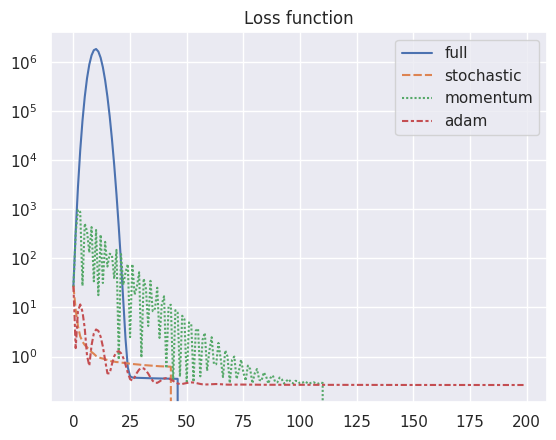

In [117]:
sns.lineplot(data=loss_history_df)
plt.title("Loss function")
plt.yscale("log")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Loss function')

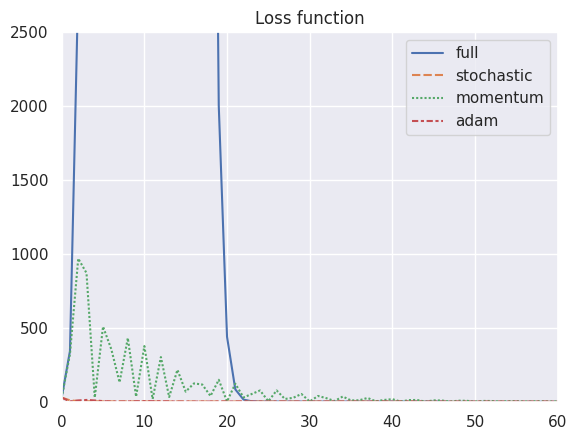

In [118]:
sns.lineplot(data=loss_history_df)
plt.ylim(-1,2500)
plt.xlim(0,60)
plt.title("Loss function")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Loss function')

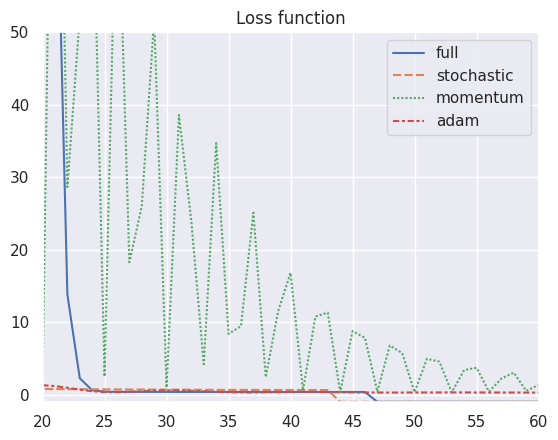

In [119]:
sns.lineplot(data=loss_history_df)
plt.ylim(-1,50)
plt.xlim(20,60)
plt.title("Loss function")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Loss function')

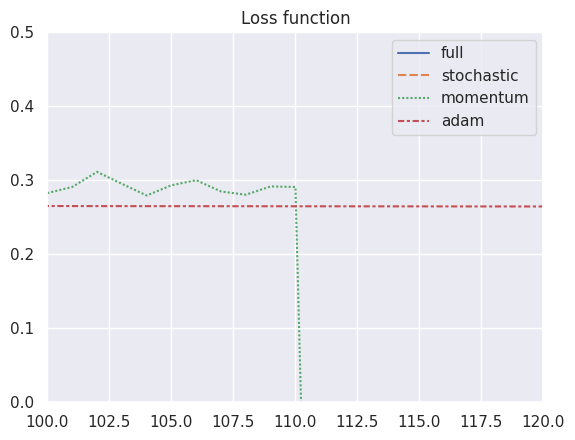

In [120]:
sns.lineplot(data=loss_history_df)
plt.ylim(0,0.5)
plt.xlim(100,120)
plt.title("Loss function")

## Задание 6. Стохастический градиентный спуск и размер батча (1 балл)

В этом задании вам предстоит исследовать влияние размера батча на работу стохастического градиентного спуска.

* Сделайте по несколько запусков (например, k = 10) стохастического градиентного спуска на обучающей выборке для каждого размера батча из перебираемого списка. Замерьте время в секундах и количество итераций до сходимости. Посчитайте среднее этих значений для каждого размера батча.
* Постройте график зависимости количества шагов до сходимости от размера батча.
* Постройте график зависимости времени до сходимости от размера батча.

Посмотрите на получившиеся результаты. Какие выводы можно сделать про подбор размера батча для стохастического градиентного спуска?

In [121]:
import time

batch_sizes = np.arange(5, 500, 10)

limit = int(0.1 * len(X_train_np))

# for faster computation, can be interchanged with full training dataset. I get it that quatity of model becomes worse, but i want to pass this HW before deadline
X_train_lite, y_train_lite = X_train_np[:limit, : ], y_train_np[:limit]

def run_descent(batch_size, k=10):
    time_elapsed = []
    iteration_numbers = []

    print(f"Batch Size: {batch_size}\n")
    for i in range(k):
        start = time.time()

        model = LinearRegression(max_iter=3_000_000, descent_config={"descent_name": "stochastic" ,"kwargs": {"lambda_": lambda_, "dimension": X_train.shape[1], "batch_size": batch_size}})
        model.fit(X_train_lite, y_train_lite)

        time_elapsed.append( time.time() - start )
        iteration_numbers.append( len(model.loss_history) - 1 )
        print(f"Elapsed time: {time_elapsed[-1]}, iters: {len(model.loss_history) - 1}")
    print("\n")
    return np.mean(time_elapsed), np.mean(iteration_numbers)

performance = {
    "batch_sizes": [],
    "time_elapsed": [],
    "iterations": []
}

for batch_size in batch_sizes:
    performance["batch_sizes"] += [batch_size]
    t, iters = run_descent(batch_size)
    performance["time_elapsed"] += [t]
    performance["iterations"] += [iters]

perf_df = pd.DataFrame(performance)
perf_df.to_csv("performance.csv")

# perf_df = pd.read_csv("performance.csv", index_col=0)
# perf_df.index = perf_df["batch_sizes"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Batch Size: 5

Elapsed time: 66.96372199058533, iters: 11036


KeyboardInterrupt: ignored

In [ ]:
sns.lineplot(data=perf_df, x=perf_df.index, y="time_elapsed")

In [ ]:
sns.lineplot(data=perf_df, x=perf_df.index, y="iterations")

## Задание 7. Регуляризация (1 балл)

В этом задании вам предстоит исследовать влияние регуляризации на работу различных методов градиентного спуска. Напомним, регуляризация - это добавка к функции потерь, которая штрафует за норму весов. Мы будем использовать l2 регуляризацию, таким образом функция потерь приобретает следующий вид:

$$
    Q(w) = \dfrac{1}{\ell} \sum\limits_{i=1}^{\ell} (a_w(x_i) - y_i)^2 + \dfrac{\mu}{2} \| w \|^2
$$

Допишите класс **BaseDescentReg** в файле `descents.py`.

Протестируйте ваше решение в контесте.

Вставьте ссылку на успешную посылку:

* **BaseDescentReg**: https://contest.yandex.ru/contest/54610/run-report/96435870/

In [122]:
class BaseDescentReg(BaseDescent):
    """
    A base class with regularization
    """

    def __init__(self, *args, mu: float = 0, **kwargs):
        """
        :param mu: regularization coefficient (float)
        """
        super().__init__(*args, **kwargs)

        self.mu = mu

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Calculate gradient of loss function and L2 regularization with respect to weights
        """
        l2_gradient: np.ndarray = np.concatenate([ self.w[0 : -1], [0] ])
        print(l2_gradient)
        return super().calc_gradient(x, y) + l2_gradient * self.mu


Найдите лучшие параметры обучения с регуляризацией аналогично 5 заданию. Будем подбирать длину шага $\lambda$ (`lambda_`) и коэффициент регуляризации $\mu$ (`mu`).

Сравните для каждого метода результаты с регуляризацией и без регуляризации (нужно опять сохранить ошибку и качество по метрике $R^2$ на обучающей и тестовой выборках и количество итераций до сходимости).

Постройте для каждого метода график со значениями функции потерь MSE с регуляризацией и без регуляризации (всего должно получиться 4 графика).

Посмотрите на получившиеся результаты. Какие можно сделать выводы, как регуляризация влияет на сходимость? Как изменилось качество на обучающей выборке? На тестовой? Чем вы можете объяснить это?

In [123]:
# import warnings
# warnings.filterwarnings('default')

In [124]:
import warnings
# warnings.filterwarnings('ignore')


lambdas = [1e-2, 1e-1, 1]
mu_s = [ 0.1, 0.5, 1, 10 ]
descents = ["full", "stochastic", "momentum", "adam"]

X_train_np = X_train.toarray()
y_train_np = y_train.to_numpy()

limit = int(0.1 * len(X_train_np))

# for faster computation
X_train_lite, y_train_lite = X_train_np[:limit, : ], y_train_np[:limit]

best_params = {}

for descent_name in descents:
    params = np.zeros(shape=(len(mu_s), len(lambdas)))
    models = params.copy().tolist()
    for mu in range(len(mu_s)):
        for l in range(len(lambdas)):
            descent_config={"descent_name": descent_name, "regularized": True, "kwargs": {"mu": mu_s[mu], "lambda_": lambdas[l], "dimension": X_train_lite.shape[1]} }
            model = LinearRegression(max_iter=3_000_000, descent_config=descent_config )
            model.fit(X_train_lite, y_train_lite)
            mse = model.loss_history[-1]

            if np.isnan(mse):
                params[mu][l] = np.inf
            else:
                params[mu][l] = mse

            models[mu][l] = model
            print(mse, mu_s[mu], lambdas[l])

    best_mu_index, best_l_index = np.where(params == np.min(params))
    best_mu_index, best_l_index =  best_mu_index[0], best_l_index[0]
    mu = mu_s[best_mu_index]
    lambda_ = lambdas[best_l_index]
    mse = params[best_mu_index][best_l_index]
    optimal = (mse, model, mu, lambda_)

    print(f"\n{descent_name}:\n    Best params: {optimal}")
    best_params[descent_name] = optimal


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


7.2352533138140025 0.1 0.01
0.5377384192372996 0.1 0.1
0.3133697958766582 0.1 1
6.181760013821885 0.5 0.01
0.5371298717070644 0.5 0.1
0.360663237228856 0.5 1
6.139643772501011 1 0.01
0.7014196608595225 1 0.1
0.4175508665303639 1 1
17.364083585662158 10 0.01
1.154922153658186 10 0.1
0.9271420795470577 10 1

full:
    Best params: (0.3133697958766582, <linear_regression.LinearRegression object at 0x7ceb6bd25420>, 0.1, 1)
7.011784599739566 0.1 0.01
0.5348239681224095 0.1 0.1
0.32104041269892813 0.1 1
6.028064918769987 0.5 0.01
0.5402259238930507 0.5 0.1
0.3661417706811156 0.5 1
5.021749358931715 1 0.01
0.6922728006530359 1 0.1
0.4254659046691559 1 1
13.974031591848693 10 0.01
1.062369146313948 10 0.1
0.9427271886262145 10 1

stochastic:
    Best params: (0.32104041269892813, <linear_regression.LinearRegression object at 0x7ceb6bd25450>, 0.1, 1)
0.4754318666399254 0.1 0.01
0.3128144621291096 0.1 0.1
0.3283713069588986 0.1 1
0.5035709056389579 0.5 0.01
0.3702057679599934 0.5 0.1
0.380456060

In [136]:
models = {name: params[1] for (name, params) in best_params.items()}
data = {name: model.loss_history for (name, model) in models.items()}
iterations = {model_name: len(loss_history) - 1 for (model_name, loss_history) in data.items()}
metrics = {name: evaluate_r2(model, X_test, y_test) for (name, model) in models.items()}

In [137]:
list_len = [len(i) for i in data.values()]
max_iter = max(list_len)

for m_name, loss in data.items():
    data[m_name] = loss + [-1] * (max_iter - len(loss) )

loss_history_df_reg = pd.DataFrame(data=data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [138]:
# loss_history_df = loss_history_df.replace([np.inf, -np.inf], np.nan)
# loss_history_df = loss_history_df.fillna(loss_history_df.mean())
loss_history_df_reg

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,full,stochastic,momentum,adam
0,2.505822e+01,2.372381e+01,1.949125e+01,21.960788
1,5.730962e+01,2.246639e+02,1.027367e+02,41.411543
2,2.271232e+03,8.833223e+03,4.040014e+03,31.411000
3,6.674973e+04,2.259975e+05,9.649936e+04,20.328937
4,1.660026e+06,5.213685e+06,2.218886e+06,12.879919
...,...,...,...,...
1984,-1.000000e+00,9.210726e-01,-1.000000e+00,-1.000000
1985,-1.000000e+00,9.121947e-01,-1.000000e+00,-1.000000
1986,-1.000000e+00,9.246746e-01,-1.000000e+00,-1.000000
1987,-1.000000e+00,9.357726e-01,-1.000000e+00,-1.000000


In [139]:
pd.DataFrame(data=metrics,index=["R^2"])

,full,stochastic,momentum,adam
R^2,0.292447,0.280816,-0.30581,0.29385


In [140]:
pd.DataFrame(data=iterations,index=["iter"])

,full,stochastic,momentum,adam
iter,137,1988,341,96


(0.0, 400.0)

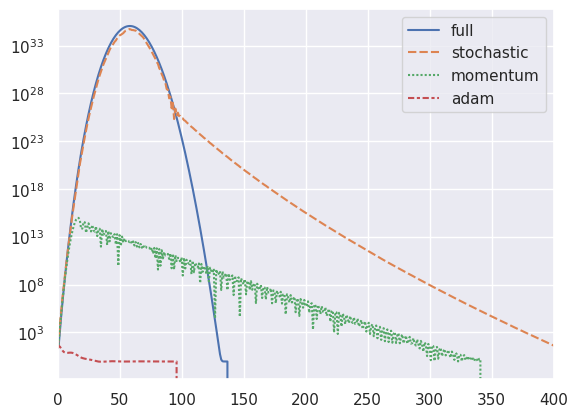

In [141]:
sns.lineplot(loss_history_df_reg)
plt.yscale("log")
plt.xlim(0,400)

(0.0, 100.0)

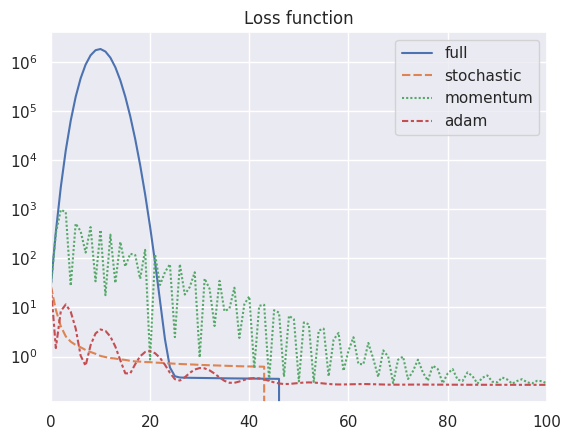

In [142]:
sns.lineplot(data=loss_history_df)
plt.title("Loss function")
plt.yscale("log")
plt.xlim(0, 100)

На удивление регуляризация помогает адам оптимизатору, однако не помогает остальным спускам, а только делает их хуже, веса улетают в небеса. Требуется больше итераций для сходимости. R^2 для моментума негативный, это означает, что эстимация очень плохая. Возможно мало данных (так как я ускорял вычисления), возможно где-то ошибка, хотя не должно быть, потому что контест прошел на отлично.

## Задание 8. Альтернативная функция потерь (1 балл)

В этом задании вам предстоит использовать другую функцию потерь для нашей задачи регрессии. В качестве функции потерь мы выбрали **Log-Cosh**:

$$
    L(y, a)
    =
    \log\left(\cosh(a - y)\right).
$$

Самостоятельно продифференцируйте данную функцию потерь чтобы найти её градиент:

`### ваше решение тут ###`

Программно реализуйте градиентный спуск с данной функцией потерь в файле `descents.py`, обучите все четыре метода (без регуляризации) аналогично 5 заданию, сравните их качество с четырьмя методами из 5 задания.

Пример того, как можно запрограммировать использование нескольких функций потерь внутри одного класса градиентного спуска:


```python
from enum import auto
from enum import Enum

import numpy as np

class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()

...
class BaseDescent:
    def __init__(self, loss_function: LossFunction = LossFunction.MSE):
        self.loss_function: LossFunction = loss_function

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        if self.loss_function is LossFunction.MSE:
            return ...
        elif self.loss_function is LossFunction.LogCosh:
            return ...
...

```

In [132]:
# YOUR CODE:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Кулинарно-социализационный бонус. (0.5 балла).

Как мы знаем, осень прекрасная пора, время пробовать новое и делиться теплом с друзьями и близкими. Выберите рецепт, который соответствует вашему настроению, приготовьте выбранное блюдо и угостите хотя бы одного человека им. Кратко опишите ваши впечатления, прикрепите рецепт и фотографии блюда и довольного гостя.

`### ваш кулинарный опыт тут ###`

### Бонус 1. Другие методы градиентного спуска (1 балл).

По желанию выберите метод градиентного спуска из следующего списка и самостоятельно реализуйте его в файле `descents.py`. Обучите линейную регрессию с помощью этого метода, сравните с методами из основной части домашнего задания.

`AdaMax` (вариация Adam основанная на $l_{\infty}$), `Nadam` (вариация Adam совмещенная с методом импульса Нестерова), `AMSGrad` (ещё одна вариация Adam).

In [133]:
# YOUR CODE:

### Бонус 2. Другие функции потерь (1 балл).

Аналогично 8 заданию реализуйте две функции потерь - **MAE** и **Huber**.

Самостоятельно продифференцируйте данные функции потерь, чтобы найти их градиенты:

`### ваше решение тут ###`

Программно реализуйте градиентный спуск с данными функциями потерь в файле `descents.py`, обучите все четыре метода (без регуляризации) аналогично 5 заданию, сравните их качество с четырьмя методами из 5 задания.

Сравните между собой *для каждого метода отдельно* качество для разных функций потерь. Какая оказалась лучше? Как вы думаете почему?

In [134]:
# YOUR CODE: